# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 

In [2]:
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


c:\Users\Andrea\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [6]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
) #getting the file path
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          ) # only taking these categories from dataframe
df = df.merge(cat_df, on = 'ticker', how = 'left') # effectively a left join, all obseravtions from left table, grabbing only matching observations from right-hand table
# Joining on 'ticker' 
# creates extended dataframe

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [7]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Returns', 'Listing Exchange_x',
       'Market Category_x', 'Listing Exchange_y', 'Market Category_y',
       'Listing Exchange', 'Market Category'],
      dtype='object')

In [8]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open'] # creating returns like in assignment 1
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1)) # create a forward looking variable - create target to check if tomorrow, will the return be positive
    )
    .reset_index(drop=True) # drop any indices put in
    .dropna(subset = ['target']) # drop any missing values from the dataset
    )
df

C:\Users\Andrea\AppData\Local\Temp\ipykernel_8256\3768964069.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.assign(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,...,Market Category_x,Listing Exchange_y,Market Category_y,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,...,,N,,N,,-0.010547,0.0,0.25,-0.04,0.0
1,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,...,,N,,N,,-0.000666,0.0,0.46,0.00,0.0
2,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,...,,N,,N,,-0.009333,0.0,0.27,-0.09,1.0
3,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,...,,N,,N,,0.006057,1.0,0.30,0.25,0.0
4,ACN,2001-07-26,14.95,14.99,14.50,14.50,10.900705,6335300.0,ACN.csv,2001,...,,N,,N,,-0.030100,0.0,0.49,-0.45,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239587,ZIXI,2003-06-25,4.15,4.18,3.99,4.04,4.040000,112100.0,ZIXI.csv,2003,...,Q,Q,Q,Q,Q,-0.049412,0.0,0.19,-0.11,0.0
239588,ZIXI,2003-06-26,4.04,4.19,3.86,4.00,4.000000,515300.0,ZIXI.csv,2003,...,Q,Q,Q,Q,Q,-0.009901,0.0,0.33,-0.04,0.0
239589,ZIXI,2003-06-27,4.00,4.05,3.79,3.85,3.850000,162400.0,ZIXI.csv,2003,...,Q,Q,Q,Q,Q,-0.037500,0.0,0.26,-0.15,0.0
239590,ZIXI,2003-06-30,3.84,4.00,3.72,3.77,3.770000,119900.0,ZIXI.csv,2003,...,Q,Q,Q,Q,Q,-0.020779,0.0,0.28,-0.07,1.0


In [26]:
returns = df[['returns']]
# returns = df['returns']

In [27]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)
# std_scaler.fit(returns.reshape(-1,1))

StandardScaler()

###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

In [23]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
# scaled_returns_np = std_scaler.transform(returns.reshape(-1,1))
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

,returns
count,2.395330e+05
mean,-1.479475e-18
std,1.000002e+00
min,-1.205709e+00
25%,-1.637541e-02
50%,-4.040821e-03
75%,8.444178e-03
max,4.025368e+02


+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

<Axes: xlabel='Listing Exchange'>

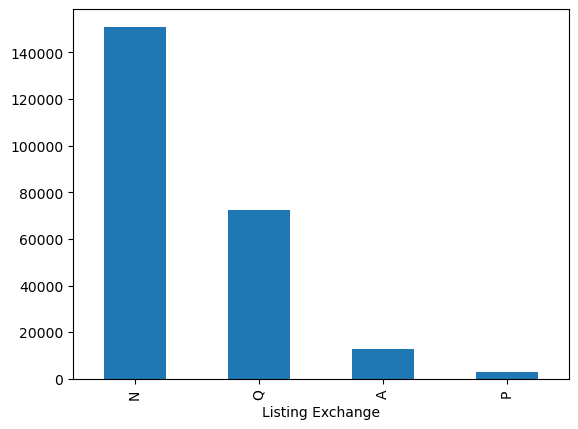

In [28]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(drop='first') # drop since values are binary, cuts 4 cols down to 3 (dummy transformation)
onehot.fit(df[['Listing Exchange']])

OneHotEncoder(drop='first')

In [32]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [34]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [ ]:
X0 = df[['Listing Exchange', 'Market Category']] # taking two categorical variables - will tomorrow bring a positive return
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42) # create train/test samples, with 20% reserved for testing

pipe1.fit(X0_train, Y0_train) # fit the pipeline, single command applied to all elements in the pipeline

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [ ]:
Y_pred_train = pipe1.predict(X0_train) # get training preds
Y_pred_test = pipe1.predict(X0_test) # get testing preds

In [39]:
Y_poba_train = pipe1.predict_proba(X0_train) #standard output of classifiers in scikit learn - score (not a calibrated probability)
Y_proba_test = pipe1.predict_proba(X0_test)

In [ ]:
res = { #opening a dictionary
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train), # (if evaluing against train set, use pred for train set, etc.)
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5436214292423783,
 'accuracy_score_test': 0.5410274072682489,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6885455693418755,
 'log_loss_test': 0.6890481947278746,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [40]:
from sklearn.compose import ColumnTransformer

In [41]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [42]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [43]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [ ]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3}) # in this classifier, we know the param decisiontree__max_depth exists and we're setting it to 3
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6789752594183754,
 'log_loss_test': 0.6796638669864612,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0,
 'accuracy_score_train': 0.5439399869536856,
 'accuracy_score_test': 0.5423472316443145}

In [ ]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15}) # max_depth we're allow the param to go
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6316582282215347,
 'log_loss_test': 1.5527246685221383,
 'cohen_kappa_train': 0.1569130595300522,
 'cohen_kappa_test': 0.05664342390392352,
 'f1_score_train': 0.5031531602371554,
 'f1_score_test': 0.4448140593127256,
 'accuracy_score_train': 0.5878277886497064,
 'accuracy_score_test': 0.5384073474925638}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [46]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [47]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,4.702392,0.393774,0.541779,0.583579,0.443662,0.502187,0.498179,0.553319,0.399899,0.459705,0.549645,0.631454,-1.692908,-0.637717,-0.259198,-0.227677
1,4.056414,0.601790,0.523556,0.589654,0.345707,0.507074,0.463989,0.561970,0.275481,0.461949,0.517032,0.641724,-2.327348,-0.629078,-0.277468,-0.224506
2,7.898541,0.848601,0.507546,0.596093,0.481836,0.498019,0.463982,0.576192,0.501119,0.438523,0.503346,0.650408,-1.822060,-0.626207,-0.271976,-0.223162
3,3.873482,0.751287,0.511752,0.590997,0.412193,0.491567,0.458054,0.568906,0.374680,0.432739,0.503064,0.643518,-2.606229,-0.630048,-0.293478,-0.224587
4,5.167272,0.494532,0.541122,0.584458,0.378537,0.482831,0.496478,0.559661,0.305875,0.424549,0.537684,0.630734,-1.572014,-0.638192,-0.262968,-0.227936


In [ ]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True) # asked for 5 folds
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,4.525011,0.721823,0.541821,0.583569,0.443543,0.502087,0.498234,0.553326,0.399671,0.459534,0.549746,0.631423,-1.702265,-0.637732,-0.259307,-0.227686
1,4.543694,0.377298,0.523347,0.589779,0.345158,0.507212,0.463565,0.562140,0.274933,0.462063,0.516761,0.641918,-2.351774,-0.628898,-0.277785,-0.224449
2,5.951679,0.884638,0.507254,0.596177,0.481278,0.500951,0.463652,0.575324,0.500297,0.443606,0.502792,0.650646,-1.837602,-0.626204,-0.272300,-0.223153
3,4.737413,0.444048,0.511731,0.590955,0.412773,0.491271,0.458122,0.568922,0.375594,0.432270,0.502922,0.643450,-2.605691,-0.630051,-0.293549,-0.224594
4,4.565167,0.544295,0.540809,0.584531,0.378131,0.482875,0.495922,0.559779,0.305556,0.424549,0.537125,0.630865,-1.574822,-0.638141,-0.263211,-0.227909


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [ ]:
pd.DataFrame(d15_dict).mean() # calculate the average, use this to evaluate models and make our decisions

fit_time                 4.864593
score_time               0.594421
test_accuracy            0.524992
train_accuracy           0.589002
test_f1                  0.412177
train_f1                 0.496879
test_precision           0.475899
train_precision          0.563898
test_recall              0.371210
train_recall             0.444404
test_roc_auc             0.521869
train_roc_auc            0.639660
test_neg_log_loss       -2.014431
train_neg_log_loss      -0.632205
test_neg_brier_score    -0.273230
train_neg_brier_score   -0.225558
dtype: float64